# Twitter Sentiment Prediction

###### Import required packages

In [38]:
import itertools
import nltk
from nltk.tokenize import word_tokenize
from html import unescape
from pyspark import SparkContext
from pyspark.mllib.feature import *
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.evaluation import MulticlassMetrics
from nltk.stem.porter import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/home/ashwin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ashwin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Get spark context

In [3]:
# sc = SparkContext()

Define imput files

In [4]:
training_file = 'data/train.csv'
test_file = 'data/test.csv'

### Data Cleaning 

List of Stop words which will be excluded while formulating features

In [5]:
stopwordList = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
                'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
                'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
                'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
                'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
                'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
                'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 
                'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 
                'now' ]

In [6]:
APOSTROPHES = {"'s" : " is", "'re" : " are", "'ll" : "will", "n't" : "not"}

Using Porter Stemer, get the root word of the input word

In [7]:
def getRootWord(word):
    stem_porter = PorterStemmer()
    return stem_porter.stem(word)

Clean Tweet Text function is used to clean the text using below mentioned methods:
1. Lowercase all characters
2. Stemming using Porter Stemmer
3. Strip punctuations
4. Replace two or more occurrences of the same character with two occurrences. i.e. ‘exciteddddd’ to ‘excitedd’
5. Replace Hash tags, ex. #xyz with xyz
6. Replace a word contains www. or http(s):// with URL 
7. Replace a word contains @someuser with AT_USER 
8. Ignore words that don’t start with an alphabet
9. Ignore stop words
10. Use html.unescape to replace html escape characters and replace with their meaning
11. Replace aposthope characters apostrophes to standard lexicons

In [8]:
def cleanTweetText(original_tweet):
    tweet_text = []
    
    # Remove html escape characters and replace with their meaning
    tweet_html_str = unescape(original_tweet)

    # Decode tweet to utf-8 format
    tweet_decoded = tweet_html_str.encode("ascii", "ignore").decode("utf8")

    tweet_clear = []
    for word in tweet_decoded.split():
        if word[0] == '@':
            tweet_clear.append("AT_USER")
        elif word[0] == '#':
            tweet_clear.append(str.lower(word[1:]))
        elif word[0:7] == 'http://' or word[0:8] == 'https://' or word[0:4] == 'www.':
            tweet_clear.append("URL")
        else:
            tweet_clear.append(word)
            
    tweet_temp = ' '.join(tweet_clear)
    
    # Remove multiple repetition of a character in word
    tweet_str = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet_temp))

    # Convert all the apostrophes to standard lexicons
    words = []
    tokens = word_tokenize(tweet_str)
    words = [APOSTROPHES[word] if word in APOSTROPHES else word for word in tokens]

    for word in words:
        if str.lower(word) in stopwordList:
            continue
        elif str.isalpha(word):
            root_word = getRootWord((str.lower(word)))
            tweet_text.append(root_word)
        else:
            continue
    
    return tweet_text

This function is used to generate the LabeledPoint opject for each tweet in file by extracting the tweet polarity and the tweet text and cleaning the tweet text.

In [9]:
def getTweetText(record):
    tweet_str = record.split(",",5)[-1].strip("\n" " " '"')
    tweet_text_cleaned = cleanTweetText(tweet_str)
    return tweet_text_cleaned

In [64]:
def getTweetLabelPoint(record):
    tweet_polarity = record.split(",", 1)[0].strip('"')
    tweet_str = record.split(",",5)[-1].strip("\n" " " '"')
    
    hashingTF = HashingTF()
    
    tweet_text_vector = hashingTF.transform(cleanTweetText(tweet_str))

    return LabeledPoint(float(tweet_polarity), tweet_text_vector)

Function to compute accuracy i.e % of correct predictions over total predictions

In [11]:
def computeAccuracy(predictionAndLabel, total_count):
    return 1.0 * predictionAndLabel.filter(lambda t: t[0] == t[1]).count() / total_count

Calculate the Accuracy, precision and Recall

In [22]:
def calculatePrecisionRecall(predictionAndLabel):
    tp = predictionAndLabel.filter(lambda t: t[0] == 1 and t[1] == 1).count()
    tn = predictionAndLabel.filter(lambda t: t[0] == 0 and t[1] == 0).count()
    fp = predictionAndLabel.filter(lambda t: t[0] == 1 and t[1] == 0).count()
    fn = predictionAndLabel.filter(lambda t: t[0] == 0 and t[1] == 1).count()
    
    total_count = tp + tn + fp + fn
    
    accuracy = (tp + tn) / total_count
#     print("Accuracy is : " + str(accuracy))
    
    precision = tp / (tp + fp)
#     print("Precision is : " + str(precision))
    
    recall = tp / (tp + fn)
#     print("Recall is : " + str(recall))
    
    f1_score = (2 * precision * recall) / (precision + recall)
#     print("F1 Score is : " + str(f1_score))
    
    return (accuracy, precision, recall, f1_score)

In [17]:
def calculateTrueAndFalsePositiveRate(predictionAndLabel):
    tp = predictionAndLabel.filter(lambda t: t[0] == 1 and t[1] == 1).count()
    tn = predictionAndLabel.filter(lambda t: t[0] == 0 and t[1] == 0).count()
    fp = predictionAndLabel.filter(lambda t: t[0] == 1 and t[1] == 0).count()
    fn = predictionAndLabel.filter(lambda t: t[0] == 0 and t[1] == 1).count()
    
    true_positive_rate = (tp) / (tp + fn)
#     print("True Positive rate is : " + str(true_positive_rate))
    
    false_positive_rate = fp / (fp + tn)
#     print("False Positive rate is : " + str(false_positive_rate))
    
    return (false_positive_rate, true_positive_rate)

Generate RDD for Train file and Test file after cleaning data

In [65]:
train_file = sc.textFile(training_file)

text_docs = train_file.map(getTweetText)
polarity_docs = train_file.map(lambda line: line.split(",", 1)[0].strip('"'))

hashingTF = HashingTF()
    
tweet_text_vector = hashingTF.transform(text_docs)
tweet_text_vector.cache()

model = IDF().fit(tweet_text_vector)
train_tweet_text_tfidf = model.transform(tweet_text_vector)

train_doc_zip_rdd = polarity_docs.zip(train_tweet_text_tfidf)
train_docs = train_doc_zip_rdd.map(lambda rec: LabeledPoint(float(rec[0]), rec[1]))

In [66]:
test_docs = sc.textFile(test_file).map(getTweetLabelPoint)

###### Randamize split of Train data

In [21]:
# Split data aproximately into training (60%) and test (40%)
training, test = train_docs.randomSplit([0.85, 0.15], seed=0)

modelNB = NaiveBayes.train(training, 1.0)

# Make prediction and test accuracy.
predictionAndLabelNB = test.map(lambda p: (modelNB.predict(p.features), p.label))

accuracy,presion,recall,f1score = calculatePrecisionRecall(predictionAndLabelNB) 

print(accuracy)

Accuracy is : 0.7161150839846998
Precision is : 0.7286212914485166
Recall is : 0.6919124958568114
F1 Score is : 0.7097925875552533
0.7161150839846998


###### Train on full train data

In [16]:
# Train documents
model = NaiveBayes.train(train_docs, 1.0)

###### Make Predictions on full test data

In [113]:
# Make prediction and test accuracy.
predictionAndLabelOnTestNB = test_docs.map(lambda p: (model.predict(p.features), p.label))

accuracy,presion,recall,f1score  = calculatePrecisionRecall(predictionAndLabelOnTestNB) 

print(accuracy)

Accuracy is : 0.7604456824512534
Precision is : 0.7823529411764706
Recall is : 0.7307692307692307
F1 Score is : 0.7556818181818181


###### Make Predictions on full train data

In [94]:
# Make prediction and test accuracy.
predictionAndLabelOnTrain = train_docs.map(lambda p: (model.predict(p.features), p.label))

accuracy,presion,recall,f1score = calculatePrecisionRecall(predictionAndLabelOnTrain) 

print(accuracy)

Accuracy is : 0.857225
Precision is : 0.8692438885730529
Recall is : 0.84095
F1 Score is : 0.8548628935932299


## K-Fold algorithm for naive bayes

In [30]:
train_file_dict = []

train_file_dict = train_docs.randomSplit([0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], seed=0)

In [50]:
kfold = 10
accuracy_NB = []
accuracy_test_NB = []
accuracy_train_NB = []

total_accuracy_NB = 0
total_precision_NB = 0 
total_recall_NB = 0
total_f1score_NB = 0

total_accuracy_test_NB = 0
total_precision_test_NB = 0 
total_recall_test_NB = 0 
total_f1score_test_NB = 0

total_accuracy_train_NB = 0
total_precision_train_NB = 0 
total_recall_train_NB = 0 
total_f1score_train_NB = 0

avg_accuracy_NB = 0
avg_precision_NB = 0 
avg_recall_NB = 0
avg_f1score_NB = 0

avg_accuracy_test_NB = 0
avg_precision_test_NB = 0 
avg_recall_test_NB = 0 
avg_f1score_test_NB = 0

avg_accuracy_train_NB = 0
avg_precision_train_NB = 0 
avg_recall_train_NB = 0 
avg_f1score_train_NB = 0


for i in range(0, kfold):
    test_data = sc.parallelize([])
    test_data = train_file_dict[i]
    train_data_flag = False
    train_data = sc.parallelize([])
    for j in range(0, kfold):
        if i != j:
            if train_data_flag == False:
                train_data = train_file_dict[j]
                train_data_flag = True
            else:
                train_data = train_data.union(train_file_dict[j])
        else:
            continue
    
    # Train documents
    model = NaiveBayes.train(train_data, 1.0)

    # Test Part of train data
    # Make prediction and test accuracy.
    predictionAndLabel = test_data.map(lambda p: (model.predict(p.features), p.label))
    
    accuracy,precision,recall,f1score = calculatePrecisionRecall(predictionAndLabel) 
    accuracy_NB.append(accuracy)
#     print(str(i) + " : " + str(accuracy))
    total_accuracy_NB += accuracy
    total_precision_NB += precision
    total_recall_NB += recall
    total_f1score_NB += f1score
    
    # Test Docs prediction
    # Make prediction and test accuracy.
    predictionAndLabel = test_docs.map(lambda p: (model.predict(p.features), p.label))
    
    accuracy,precision,recall,f1score = calculatePrecisionRecall(predictionAndLabel) 
    accuracy_test_NB.append(accuracy)
#     print(str(i) + " : " + str(accuracy))
    total_accuracy_test_NB += accuracy
    total_precision_test_NB += precision
    total_recall_test_NB += recall
    total_f1score_test_NB += f1score
    
    # Train Part of train data
    # Make prediction and test accuracy.
    predictionAndLabel = train_data.map(lambda p: (model.predict(p.features), p.label))
    
    accuracy,precision,recall,f1score = calculatePrecisionRecall(predictionAndLabel) 
    
    accuracy_train_NB.append(accuracy)
#     print(str(i) + " : " + str(accuracy))
    total_accuracy_train_NB += accuracy
    total_precision_train_NB += precision
    total_recall_train_NB += recall
    total_f1score_train_NB += f1score

    
avg_accuracy_NB = float(total_accuracy_NB/kfold)
avg_precision_NB = float(total_precision_NB/kfold)
avg_recall_NB = float(total_recall_NB/kfold)
avg_f1score_NB = float(total_f1score_NB/kfold)

avg_accuracy_test_NB = float(total_accuracy_test_NB/kfold)
avg_precision_test_NB = float(total_precision_test_NB/kfold)
avg_recall_test_NB = float(total_recall_test_NB/kfold)
avg_f1score_test_NB = float(total_f1score_test_NB/kfold)

avg_accuracy_train_NB = float(total_accuracy_train_NB/kfold)
avg_precision_train_NB = float(total_precision_train_NB/kfold)
avg_recall_train_NB = float(total_recall_train_NB/kfold)
avg_f1score_train_NB = float(total_f1score_train_NB/kfold)


print("K-fold Values:")
print("Avg k-fold accuracy :" + str(avg_accuracy_NB))
print("Avg k-fold precision :" + str(avg_precision_NB))
print("Avg k-fold recall :" + str(avg_recall_NB))
print("Avg k-fold F1score :" + str(avg_f1score_NB))

print("\nTest Values:")
print("Avg test accuracy :" + str(avg_accuracy_test_NB))
print("Avg test precision :" + str(avg_precision_test_NB))
print("Avg test recall :" + str(avg_recall_test_NB))
print("Avg test F1score :" + str(avg_f1score_test_NB))

print("\nK-fold Train, Test-doc Test Values:")
print("Avg Train accuracy :" + str(avg_accuracy_train_NB))
print("Avg Train precision :" + str(avg_precision_train_NB))
print("Avg Train recall :" + str(avg_recall_train_NB))
print("Avg Train F1score :" + str(avg_f1score_train_NB))

K-fold Values:
Avg k-fold accuracy :0.7150153465842254
Avg k-fold precision :0.7264455459251299
Avg k-fold recall :0.6899021757401264
Avg k-fold F1score :0.7076388577515431

Test Values:
Avg test accuracy :0.7562674094707521
Avg test precision :0.7755672890929253
Avg test recall :0.7307692307692308
Avg test F1score :0.7524078098483808

K-fold Train, Test-doc Test Values:
Avg Train accuracy :0.8323572433422919
Avg Train precision :0.8481331204385972
Avg Train recall :0.8097247384639162
Avg Train F1score :0.8284709862802426


# Logistic Regression

###### Randamize split of Train data

In [95]:
# Split data aproximately into training (60%) and test (40%)
trainingLR, testLR = train_docs.randomSplit([0.85, 0.15], seed=0)

modelLR = LogisticRegressionWithLBFGS.train(trainingLR,iterations=150, regType='l2')

# Make prediction and test accuracy.
predictionAndLabelLR = testLR.map(lambda p: (modelLR.predict(p.features), p.label))

accuracy = calculatePrecisionRecall(predictionAndLabelLR) 


Accuracy is : 0.7329951771162482
Precision is : 0.73127969850893
Recall is : 0.7396420285051376
F1 Score is : 0.735437093186125


###### Train on full train data

In [67]:
# Train documents
modelLR = LogisticRegressionWithLBFGS.train(train_docs,iterations=150, regType='l2')

###### Make Predictions on full test data

In [68]:
# Make prediction and test accuracy.
predictionAndLabelOnTestLR = test_docs.map(lambda p: (modelLR.predict(p.features), p.label))

accuracy = calculatePrecisionRecall(predictionAndLabelOnTestLR) 

###### Make Predictions on full train data

In [74]:
# Make prediction on full training data
predictionAndLabelOnTrainLR = train_docs.map(lambda p: (modelLR.predict(p.features), p.label))

accuracy = calculatePrecisionRecall(predictionAndLabelOnTrainLR) 

0.9233125


## K-Fold algorithm for Logistic Regression

In [32]:
kfold = 10
accuracy_LR = []
accuracy_test_LR = []
accuracy_train_LR = []

total_accuracy_LR = 0
total_precision_LR = 0 
total_recall_LR = 0
total_f1score_LR = 0

total_accuracy_test_LR = 0
total_precision_test_LR = 0 
total_recall_test_LR = 0 
total_f1score_test_LR = 0

total_accuracy_train_LR = 0
total_precision_train_LR = 0 
total_recall_train_LR = 0 
total_f1score_train_LR = 0


avg_accuracy_LR = 0
avg_precision_LR = 0 
avg_recall_LR = 0
avg_f1score_LR = 0

avg_accuracy_test_LR = 0
avg_precision_test_LR = 0 
avg_recall_test_LR = 0 
avg_f1score_test_LR = 0

avg_accuracy_train_LR = 0
avg_precision_train_LR = 0 
avg_recall_train_LR = 0 
avg_f1score_train_LR = 0


for i in range(0, kfold):
    test_data = sc.parallelize([])
    test_data = train_file_dict[i]
    train_data_flag = False
    train_data = sc.parallelize([])
    for j in range(0, kfold):
        if i != j:
            if train_data_flag == False:
                train_data = train_file_dict[j]
                train_data_flag = True
            else:
                train_data = train_data.union(train_file_dict[j])
        else:
            continue
    
    # Train documents
    model = LogisticRegressionWithLBFGS.train(train_data,iterations=150, regType='l2')

    # Test Part of train data
    # Make prediction and store accuracy on test part of train data.
    predictionAndLabel = test_data.map(lambda p: (model.predict(p.features), p.label))
    
    accuracy,precision,recall,f1score = calculatePrecisionRecall(predictionAndLabel) 
    
    accuracy_LR.append(accuracy)
#     print(str(i) + " : " + str(accuracy))
    total_accuracy_LR += accuracy
    total_precision_LR += precision
    total_recall_LR += recall
    total_f1score_LR += f1score
    
    # Test Docs prediction
    # Make prediction and test accuracy.
    predictionAndLabel = test_docs.map(lambda p: (model.predict(p.features), p.label))
    
    accuracy,precision,recall,f1score = calculatePrecisionRecall(predictionAndLabel) 
    
    accuracy_test_LR.append(accuracy)
#     print(str(i) + " : " + str(accuracy))
    total_accuracy_test_LR += accuracy
    total_precision_test_LR += precision
    total_recall_test_LR += recall
    total_f1score_test_LR += f1score

    # Train Part of train data
    # Make prediction and test accuracy.
    predictionAndLabel = train_data.map(lambda p: (model.predict(p.features), p.label))
    
    accuracy,precision,recall,f1score = calculatePrecisionRecall(predictionAndLabel) 
    
    accuracy_train_LR.append(accuracy)
#     print(str(i) + " : " + str(accuracy))
    total_accuracy_train_LR += accuracy
    total_precision_train_LR += precision
    total_recall_train_LR += recall
    total_f1score_train_LR += f1score


avg_accuracy_LR = float(total_accuracy_LR/kfold)
avg_precision_LR = float(total_precision_LR/kfold)
avg_recall_LR = float(total_recall_LR/kfold)
avg_f1score_LR = float(total_f1score_LR/kfold)

avg_accuracy_test_LR = float(total_accuracy_test_LR/kfold)
avg_precision_test_LR = float(total_precision_test_LR/kfold)
avg_recall_test_LR = float(total_recall_test_LR/kfold)
avg_f1score_test_LR = float(total_f1score_test_LR/kfold)

avg_accuracy_train_LR = float(total_accuracy_train_LR/kfold)
avg_precision_train_LR = float(total_precision_train_LR/kfold)
avg_recall_train_LR = float(total_recall_train_LR/kfold)
avg_f1score_train_LR = float(total_f1score_train_LR/kfold)

print("K-fold Train-Test Values:")
print("Avg k-fold accuracy :" + str(avg_accuracy_LR))
print("Avg k-fold precision :" + str(avg_precision_LR))
print("Avg k-fold recall :" + str(avg_recall_LR))
print("Avg k-fold F1score :" + str(avg_f1score_LR))

print("K-fold Train, Test-doc Test Values:")
print("Avg test accuracy :" + str(avg_accuracy_test_LR))
print("Avg test precision :" + str(avg_precision_test_LR))
print("Avg test recall :" + str(avg_recall_test_LR))
print("Avg test F1score :" + str(avg_f1score_test_LR))

print("K-fold Train, Test-doc Test Values:")
print("Avg Train accuracy :" + str(avg_accuracy_train_LR))
print("Avg Train precision :" + str(avg_precision_train_LR))
print("Avg Train recall :" + str(avg_recall_train_LR))
print("Avg Train F1score :" + str(avg_f1score_train_LR))

K-fold Train-Test Values:
Avg k-fold accuracy :0.7222826957918002
Avg k-fold precision :0.7251359405523898
Avg k-fold recall :0.715983083770586
Avg k-fold F1score :0.7204995495662077
K-fold Train, Test-doc Test Values:
Avg test accuracy :0.7498607242339832
Avg test precision :0.7294323363688702
Avg test recall :0.8060439560439561
Avg test F1score :0.7656818012956886
K-fold Train, Test-doc Test Values:
Avg Train accuracy :0.8702240056405414
Avg Train precision :0.8733321225759354
Avg Train recall :0.8660613769317773
Avg Train F1score :0.869681398093816


## Print graph of accuracy 

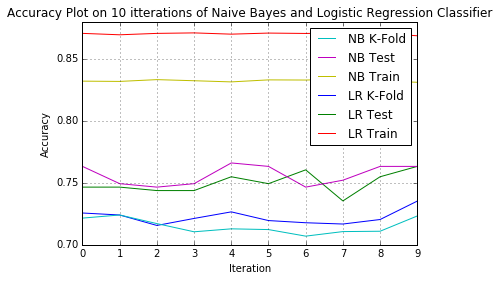

In [57]:
%matplotlib inline

kfold_index = [x for x in range(0, kfold)]

kfold_plot_LR, = plt.plot(kfold_index, accuracy_LR, label="LR K-fold")
test_plot_LR, = plt.plot(kfold_index, accuracy_test_LR, label="LR Test")
train_plot_LR, = plt.plot(kfold_index, accuracy_train_LR, label="LR Train")

kfold_plot_NB, = plt.plot(kfold_index, accuracy_NB, label="NB K-fold")
test_plot_NB, = plt.plot(kfold_index, accuracy_test_NB, label="NB Test")
train_plot_NB, = plt.plot(kfold_index, accuracy_train_NB, label="NB Train")


plt.legend([kfold_plot_NB, test_plot_NB, train_plot_NB, kfold_plot_LR, test_plot_LR, train_plot_LR], ['NB K-Fold', 'NB Test', 'NB Train', 'LR K-Fold', 'LR Test', 'LR Train'])

plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.title('Accuracy Plot on 10 itterations of Naive Bayes and Logistic Regression Classifier')


plt.grid(True)
plt.show()


###### Run Logistic regression for n times and plot ROC curve

In [52]:
# Train documents
modelLR = LogisticRegressionWithLBFGS.train(train_docs,iterations=150, regType='l2')

In [53]:
roc_x = []
roc_y = []

for i in range(0, 100,2):
    
    modelLR.setThreshold(i/100)
    
    predictionAndLabelROCLR = test_docs.map(lambda p: (modelLR.predict(p.features), p.label))
    
    (x, y) = calculateTrueAndFalsePositiveRate(predictionAndLabelROCLR)
    roc_x.append(x)
    roc_y.append(y)

Plot ROC curve

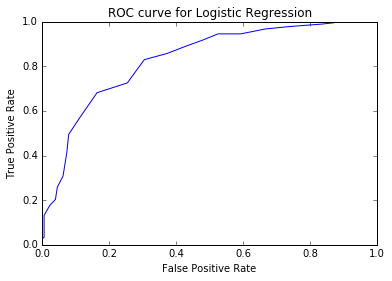

In [54]:
# This is the ROC curve
plt.plot(roc_x,roc_y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')
plt.show() 

In [69]:
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabelOnTestLR)

In [71]:
# Overall statistics
confusion_matrix_LR = metrics.confusionMatrix()

print(confusion_matrix_LR)

In [60]:
# Statistics by class
labels = train_docs.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

In [56]:
# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)